<i><b>Public-AI</b></i>

### ✎&nbsp;&nbsp;week 1. 고객 데이터와 개인화 추천시스템

# Section 1. 비개인화 추천 시스템

개인화 추천 시스템이 부상하기 전에도 추천시스템은 존재했습니다. 그 중 대표적인 방법이 '순위'를 이용한 비개인화 추천입니다. 누가 어디서 무엇을 구매했느냐 등의 정보를 복합적으로 고려하는 개인화 추천시스템과 다르게 비개인화 추천은 주어진 데이터 안에서 인기도나 최신성 등의 통계치를 내어 정렬을 하고 상위의 상품을 노출합니다. 
이번에는 본격적으로 개인화 추천시스템을 배우기에 앞서 비개인화된 방식으로 추천할 아이템을 찾아봅시다. <br>
실무 환경에서 추천 시스템을 구성해보아야 하기 때문에 관계형 데이터베이스에 접속하여 데이터에 접근하고 데이터를 가져와보겠습니다.<br>
데이터베이스에 직접 쿼리하는 쿼리문을 작성해 개인화 되진 않았지만, 기준에 따라 통계치를 계산하여 추천할 아이템을 찾아주는 시스템을 만들어봅시다. <br>


### _Objective_ 

* [데이터베이스의 데이터 확인하기] RDB에 연결하여 데이터를 확인하고, 필요에 따라 SQL 쿼리를 작성하여 데이터베이스로부터 데이터를 가져오는 방법을 배웁니다. 

* [데이터 탐색하기] Pandas를 이용해 데이터를 탐색하고, 원하는 형태에 따라 데이터를 변형하는 방법을 배웁니다. 

* [비개인화 추천: 아이템의 순위 매기기] 비개인화 추천시스템 중 대표적인 방법인 순위를 활용한 추천 방식을 배웁니다.

In [1]:
# 필요한 라이브러리 가져오기
%matplotlib inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.utils import get_file

# 영화 포스터를 가져와 주피터에서 볼 수 있도록 만들어주는 메소드
def display_posters(movieId_list):
    import requests
    from io import BytesIO
    from PIL import Image
    
    def get_poster(movieId):
        url = "https://pai-datasets.s3.ap-northeast-2.amazonaws.com/recommender_systems/movielens/img/POSTER_20M_FULL/{}.jpg".format(movieId)
        try:
            response = requests.get(url)
            b = BytesIO(response.content)
            img = np.asarray(Image.open(b))
        except:
            img = np.zeros((200,100,3))
        return img
    
    images = []
    for i in movieId_list:
        img = get_poster(i)
        images.append(img)

    columns = 5
    rows = (len(movieId_list) - 1) // columns + 1
    fig, axes = plt.subplots(rows, columns)
    axes = axes.flatten()
    fig.set_size_inches((20,rows * 5))
        
    for ind, img in enumerate(images):
        c_id = ind % columns
        r_id = ind // columns
        ax = axes[r_id*columns + c_id]
        ax.set_title(movieId_list[ind])
        ax.imshow(img)

    plt.tight_layout()

# \[데이터베이스의 데이터 확인하기\]
---

## 1. 데이터베이스에 접속하기

많은 데이터베이스 프로그램은 클라이언트/서버 형태로 가동하고 있습니다. <br>
회사 전산망 혹은 클라우드에 데이터를 일괄적으로 저장하는 서버 컴퓨터가 별도로 존재하고, 해당 서버 컴퓨터에 접속 권한을 받아 들어가는 방식으로 동작합니다. <br>
보통 데이터베이스 서버를 접속하기 위해서는 아래의 정보들이 필요합니다. <br>

| 인자  | 설명 |
|------|-----|
| host | 데이터베이스 서버의 주소(URL)|
| db   | 데이터베이스 이름| 
| user | 사용자 이름 |
| password | 사용자 비밀번호 |

`pymysql`은 파이썬이 관계형 데이터베이스인 MariaDB와 연결할 수 있게 도와주는 엔진 패키지입니다.<br>
이 패키지를 통해 우리는 파이썬을 이용해 하나인데이터베이스로 데이터를 주고 받을 수 있게 됩니다. <br>

````python
import pymysql
# import MySQLdb # 빠르지만, 세팅하는데에 좀 어려움이 있어요 -> mysql-client
````

본 수업에서는 개별 컴퓨터에 관계형 데이터베이스를 구축하지 않고, 클라우드 서버를 이용합니다. <br>
아마존 클라우드 컴퓨팅 서비스 AWS(Amazon Web Services) 중 하나인 EC2를 이용해 클라우드 서버를 생성하고, MariaDB를 구축해두었습니다.<br>

In [2]:
import pymysql

connect = pymysql.connect(
    host='movielens.czlogriww2tk.ap-northeast-2.rds.amazonaws.com',
    user='root', 
    password='rec-sys!',
    db='movielens')

## 2. Movie-Lens 데이터베이스의 테이블 확인하기

데이터베이스에는 여러 개의 테이블이 존재합니다. `connect`에 연결된 데이터베이스의 이름은 `movielens`입니다. <br>
Movie-Lense 데이터는 크게 영화의 장르가 담긴 `genres` 데이터와 영화 정보가 담긴 `movies` 데이터, 영화별 평점이 담긴 `ratings` 데이터로 나뉩니다.<br>
세 가지 데이터를 각각의 테이블로 구성하여 `movielens` 데이터베이스에 있습니다. 

데이터베이스에 어떤 테이블이 있는지를 확인하기 위해서는 아래와 같은 쿼리를 이용합니다.

````sql
SHOW TABLES -- 데이터베이스 내 테이블 이름 보여주기
````

In [3]:
# table 이름 보여주기
pd.read_sql("SHOW TABLES", connect)

,Tables_in_movielens
0,genres
1,movies
2,ratings


구체적으로 테이블 내에 어떠한 필드(열)가 있는지를 확인하기 위해서는 `DESC` 명령어를 이용하면 됩니다.

````sql
    DESC 테이블 이름 --- 테이블 내 컬럼 정보 가져오기
````    

In [4]:
# 영화 테이블 가져오기
pd.read_sql("DESC movies", connect)

,Field,Type,Null,Key,Default,Extra
0,index,bigint(20),YES,MUL,None,
1,id,bigint(20),YES,,None,
2,title,text,YES,,None,
3,release_year,bigint(20),YES,,None,


In [5]:
# 장르 테이블 가져오기
pd.read_sql("DESC genres", connect)

,Field,Type,Null,Key,Default,Extra
0,index,bigint(20),YES,MUL,None,
1,movie_id,bigint(20),YES,,None,
2,genre,text,YES,,None,


## 3. SQL 구문과 Pandas를 통해 데이터 확인하기

데이터베이스에서 데이터를 전부 가져오는 작업은 데이터베이스에 부하를 주고 데이터를 가져와서 띄우는 컴퓨터에도 메모리 부담이 생기기 때문에 지양해야 합니다. <br>
필요한 데이터를 가져오기 전에 샘플 데이터를 보고 데이터의 형태를 확인하고, 필요한 데이터에 맞게 쿼리를 작성해야 합니다.<br>
하지만 이번 수업에서 다루는 데이터는 그 크기가 메모리에 큰 부담을 주지 않는 정도이고, 차후 강의에서 pandas를 이용해 데이터를 핸들링할 것이므로 
<br>
테이블에서 원하는 데이터를 지정해서 가져오는 기본 문법은 아래와 같습니다.<br>
````sql
SELECT 열 이름 FROM 테이블 이름 LIMIT 가져올 데이터 수
```` 


In [6]:
%%time
### pandas 데이터 핸들링을 위해 데이터 로드하기
# movie_df = pd.read_sql("select * from movies", connect)
# rating_df = pd.read_sql("select * from ratings", connect)
# genre_df = pd.read_sql("select * from genres", connect)
# pd.to_pickle(movie_df, 'movie.pkl')
# pd.to_pickle(rating_df, 'rating.pkl')
# pd.to_pickle(genre_df, 'genre.pkl')

movie_df = pd.read_pickle('movie.pkl')
rating_df = pd.read_pickle('rating.pkl')
genre_df = pd.read_pickle('genre.pkl')

CPU times: user 244 ms, sys: 587 ms, total: 831 ms
Wall time: 830 ms


### (1) `movies` 테이블 확인하기

위의 코드를 통해 우리는 테이블 내 레코드들을 가져올 수 있습니다.

In [7]:
movie_count = pd.read_sql("""
SELECT *
FROM movies
""", connect)
movie_count

,index,id,title,release_year
0,0,1,Toy Story,1995
1,1,2,Jumanji,1995
2,2,3,Grumpier Old Men,1995
3,3,4,Waiting to Exhale,1995
4,4,5,Father of the Bride Part II,1995
...,...,...,...,...
27273,27273,131254,Kein Bund für's Leben,2007
27274,27274,131256,"Feuer, Eis & Dosenbier",2002
27275,27275,131258,The Pirates,2014
27276,27276,131260,Rentun Ruusu,2001


In [8]:
movie_first_10 = pd.read_sql("""
SELECT *
FROm movies
LIMIT 10
""", connect)
movie_first_10

,index,id,title,release_year
0,0,1,Toy Story,1995
1,1,2,Jumanji,1995
2,2,3,Grumpier Old Men,1995
3,3,4,Waiting to Exhale,1995
4,4,5,Father of the Bride Part II,1995
5,5,6,Heat,1995
6,6,7,Sabrina,1995
7,7,8,Tom and Huck,1995
8,8,9,Sudden Death,1995
9,9,10,GoldenEye,1995


`movies`에는 `id` 칼럼과 제목에 해당하는 `title` 칼럼, 영화가 개봉된 연도인 `release_year`가 있습니다. <br>
이 테이블에서 `id`와 `title`만 가져오고 싶다면 아래와 같이 작성하면 됩니다.

In [9]:
pd.read_sql("""
SELECT id, title
FROM movies
LIMIT 10
""", connect)

,id,title
0,1,Toy Story
1,2,Jumanji
2,3,Grumpier Old Men
3,4,Waiting to Exhale
4,5,Father of the Bride Part II
5,6,Heat
6,7,Sabrina
7,8,Tom and Huck
8,9,Sudden Death
9,10,GoldenEye


### (2) `genres` 테이블 확인하기

이번에는 장르 데이터를 살펴봅시다.

In [10]:
genre_df = pd.read_sql('SELECT * FROM genres LIMIT 10', connect)
print("genres 테이블의 row 갯수 :",len(genre_df))

genre_df

genres 테이블의 row 갯수 : 10


,index,movie_id,genre
0,0,1,Adventure
1,1,1,Animation
2,2,1,Children
3,3,1,Comedy
4,4,1,Fantasy
5,5,2,Adventure
6,6,2,Children
7,7,2,Fantasy
8,8,3,Comedy
9,9,3,Romance


`genres` 테이블은 `movies` 테이블의 `id`에 해당하는 `movie_id` 칼럼이 있고, 해당 영화의 장르를 나타내는 `genres` 칼럼이 있습니다. <br>
데이터를 보면, `movie_id` 1번의 장르가 Adventure, Animation, Children 등 다양함을 알 수 있습니다.<br>
2번 영화도 세 가지 장르를 가졌습니다. `movie_id`의 값이 고유하지 않다는 점을 알 수 있습니다.<br>

In [11]:
genre_count = pd.read_sql("""
SELECT genre, count(movie_id) as movie_count
FROM genres 
GROUP BY genre
""", connect)
genre_count

,genre,movie_count
0,Adventure,2329
1,Animation,1027
2,Children,1139
3,Comedy,8374
4,Fantasy,1412
5,Romance,4127
6,Drama,13344
7,Action,3520
8,Crime,2939
9,Thriller,4178


### (3) `ratings` 테이블 확인하기

`ratings` 데이터를 보면, 사용자를 나타내는 `user_id`와 사용자가 평가한 영화를 나타내는 `movie_id`, 해당 영화에 유저가 부여한 평점인 `rating`, 평점을 남긴 날짜인 `rated_at` 칼럼이 있습니다. 

In [12]:
pd.read_sql("""
SELECT * 
FROM ratings 
LIMIT 10""", connect)

,index,user_id,movie_id,rating,rated_at
0,0,1,2,3.5,1112486027
1,1,1,29,3.5,1112484676
2,2,1,32,3.5,1112484819
3,3,1,47,3.5,1112484727
4,4,1,50,3.5,1112484580
5,5,1,112,3.5,1094785740
6,6,1,151,4.0,1094785734
7,7,1,223,4.0,1112485573
8,8,1,253,4.0,1112484940
9,9,1,260,4.0,1112484826


여기서 `rated_at`은 언제 rating을 했는지를 알려주는 타임스탬프 값입니다.<br>
타임스탬프란 1970년1월1일 0시0분0초부터 몇 초가 지났는지를 나타내는 정수로, 날짜를 타임스탬프로 변환하여 쿼리하려면 아래와 같이 `datetime` 모듈을 사용하면 됩니다.<br>

In [13]:
s = datetime(2010,1,1)
ts = int(s.timestamp())
pd.read_sql(f"""
SELECT * 
FROM ratings 
WHERE rated_at >= {ts} 
LIMIT 10
""", connect)

,index,user_id,movie_id,rating,rated_at
0,1175,11,4226,5.0,1294796159
1,1231,11,5971,5.0,1294796201
2,1239,11,6291,5.0,1294796113
3,1267,11,7153,5.0,1294796132
4,1315,11,30707,5.0,1294796176
5,1339,11,34542,5.0,1294796038
6,1350,11,41569,5.0,1294795811
7,1368,11,46578,5.0,1294796119
8,1372,11,48516,4.5,1294795982
9,1373,11,48738,4.0,1294796106


이번에는 데이터가 얼마나 있는지 확인해보겠습니다.

In [14]:
%%time
pd.read_sql("""
SELECT count(*) 
FROM ratings""", connect) 

CPU times: user 1.67 ms, sys: 983 µs, total: 2.66 ms
Wall time: 17.4 s


,count(*)
0,20000263



`genres`와 `movies` 데이터는 Database에서는 상대적으로 데이터 크기가 작은 편에 속합니다. <br>
하지만 `rating` 테이블은 훨씬 더 많은 레코드(2,000만행)가 담겨 있습니다. <br>
이러한 데이터를 가져올 때 위와 같이 코드를 작성하게 되면 동시에 수천만개의 데이터를 요청하게 돼, DBMS에 심한 부하를 가져다 줍니다.<br>
이를 방지해 주기 위해서는 아래와 같이, Chunk 단위로 조금씩 요청한 후 이를 합쳐주는 방식이 보다 안전하고 효율적입니다.<br>

````python
# 방법 1. 한 번에 가져오기
pd.read_sql('SELECT * from ratings', connect) # 금지, 한번에 2000만줄을 동시에 가져옴


# 방법2. chunk 단위로 쪼개서 요청하기. 한번에 10만줄 씩 가져옴
chunks = pd.read_sql('SELECT * from ratings', connect, chunksize=100000)
rating_df = pd.concat([chunk for chunk in chunks])# Chunk 단위로 날라온 Dataframe을 하나로 합쳐주기
````

*caution*

해당 코드는 네트워크 환경에 따라 최대 10분가량의 시간이 소요됩니다. 전체 데이터를 한 번에 처리할 일이 아니라면, 사용하지 않습니다.

# \[ 데이터 탐색하기 \]
---

Pandas는 파이썬의 대표적인 데이터 분석 패키지입니다. 위에서 다루었던 `pd.read_sql` 또한 Pandas의 기능 중 하나로서, Database의 레코드들을 데이터프레임으로 변환하여 파이썬에서 다루기 편하게 만들어줍니다. <br>
Pandas는 '코드로 치는 엑셀'과 비슷하다고 생각하면 됩니다. 코드로서 테이블에서 필요한 정보들을 탐색하고, 계산하고, 시각화하는 기능을 제공해줍니다.<br>

## 1. 각 테이블에 대한 주요 통계정보 확인하기

### (1) `movies` 테이블  탐색하기

다시 `movies` 데이터를 확인해봅시다.

In [15]:
# read 10 rows

pd.read_sql('SELECT * FROM movies LIMIT 10', connect)

,index,id,title,release_year
0,0,1,Toy Story,1995
1,1,2,Jumanji,1995
2,2,3,Grumpier Old Men,1995
3,3,4,Waiting to Exhale,1995
4,4,5,Father of the Bride Part II,1995
5,5,6,Heat,1995
6,6,7,Sabrina,1995
7,7,8,Tom and Huck,1995
8,8,9,Sudden Death,1995
9,9,10,GoldenEye,1995


일단 몇 년도 영화부터 몇 년도 영화까지 있는지 알아봅시다. 이를 위해서 우선 집계함수를 배워보도록 하겠습니다.<br>
집계 함수에는 여러 가지 존재하고, 대표적으로 아래와 같은 함수들이 있습니다.

| 집계 함수 | 기능 |
| ---- | --- |
| `COUNT(열 이름)` | 데이터의 갯수를 세기 |
| `SUM(열 이름)` | 데이터의 합계를 구하기 |
| `AVG(열 이름)` | 데이터의 평균을 구하기 |
| `MAX(열 이름)` | 데이터의 최댓값 구하기 |
| `MIN(열 이름)` | 데이터의 최솟값 구하기 |


In [16]:
# min and max rows
pd.read_sql("""
SELECT MIN(release_year), MAX(release_year) FROM movies
""", connect)

,MIN(release_year),MAX(release_year)
0,1891,2015


1891년도 영화부터 2015년도 영화까지 데이터가 있습니다.
이번에는 출시 연도별로 얼마나 많은 영화의 데이터가 있는지 살펴봅시다. 이를 수행하기 위해서는 Group by 구문을 배워보도록 하겠습니다.<br>
group by 는 어떤 기준을 중심으로 데이터를 합쳐 집계 함수를 적용하고자 할 때 사용됩니다.<br>

````sql
SELECT 집계함수(열 이름) 
FROM 테이블 이름 
GROUP BY 집계 기준 열 이름
````

연도를 집계 기준 열(그룹)로 두고, `id` 칼럼에 `count`함수를 적용하게 되면 해당 그룹의 `id` 갯수를 카운트해줍니다.

In [17]:
released_movie_count_per_year = pd.read_sql('''
SELECT release_year, count(id) as movie_count 
FROM movies 
GROUP BY release_year''', connect)
released_movie_count_per_year.head()

,release_year,movie_count
0,1995,474
1,1994,433
2,1996,509
3,1976,199
4,1992,335


위의 결과를 시각적으로 표시하려면 아래와 같이 작성하면 됩니다.

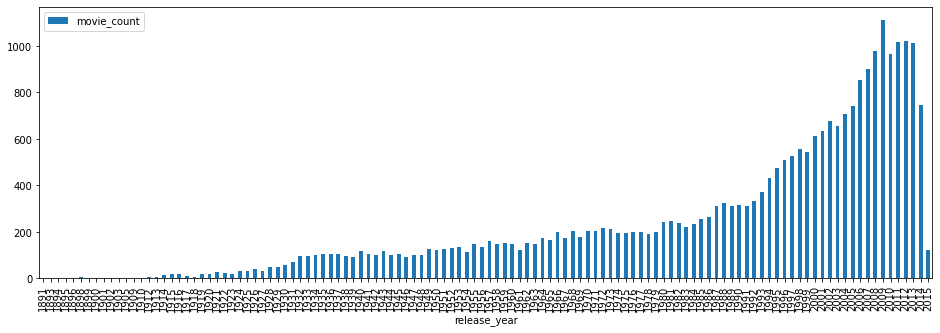

In [18]:
(
    released_movie_count_per_year
    .sort_values('release_year')
    .set_index('release_year')
    .plot(kind='bar', figsize=(16,5))
)
plt.show()

그래프를 보면, 1990년대 이후 영화의 평점이 많고, 최근인 2014년도와 2015년도 영화의 평점이 아직 많이 쌓이지 않았음을 알 수 있습니다. 

### (2) `genres` 테이블 탐색하기

`genres` 테이블을 간단히 탐색해보겠습니다. 

In [19]:
pd.read_sql('SELECT * from genres limit 10',connect)

,index,movie_id,genre
0,0,1,Adventure
1,1,1,Animation
2,2,1,Children
3,3,1,Comedy
4,4,1,Fantasy
5,5,2,Adventure
6,6,2,Children
7,7,2,Fantasy
8,8,3,Comedy
9,9,3,Romance


장르별로 얼마나 많은 영화 데이터가 있는지 확인하기 위해서는 아래와 같이 `GROUP BY` 구문을 이용합니다.

In [20]:
genre_count = pd.read_sql("""
SELECT genre, count(movie_id) as movie_count
FROM genres 
GROUP BY genre
""", connect)
genre_count

,genre,movie_count
0,Adventure,2329
1,Animation,1027
2,Children,1139
3,Comedy,8374
4,Fantasy,1412
5,Romance,4127
6,Drama,13344
7,Action,3520
8,Crime,2939
9,Thriller,4178


이를 내림차순으로 정렬하고자 한다면, `ORDER BY 정렬 기준 열 이름 DESC`를 이용하면 됩니다.

```` sql
SELECT 열 이름 
FROM 테이블 이름 
ORDER BY 정렬기준 열 이름 [DESC|ASC]
````

In [21]:
genre_count = pd.read_sql("""
SELECT genre, count(movie_id) as movie_count
FROM genres 
GROUP BY genre
ORDER BY movie_count DESC
""", connect)
genre_count

,genre,movie_count
0,Drama,13344
1,Comedy,8374
2,Thriller,4178
3,Romance,4127
4,Action,3520
5,Crime,2939
6,Horror,2611
7,Documentary,2471
8,Adventure,2329
9,Sci-Fi,1743


장르는 총 19가지이고, 장르가 없는 영화는 246개입니다. 드라마 장르의 영화가 가장 많고, IMAX 장르의 영화가 가장 적습니다. 아마도 IMAX가 등장한지 얼마 되지 않았기 때문인 것으로 짐작할 수 있습니다.

<AxesSubplot:ylabel='movie_count'>

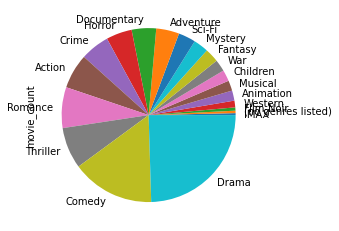

In [22]:
(
    genre_count
    .set_index('genre')['movie_count']
    .sort_values()
    .plot(kind='pie')
)

이번에는 영화별로 몇 개의 장르 정보를 가지고 있는지 살펴봅시다. 

In [23]:
num_genres_per_movie_id = pd.read_sql('''
SELECT movie_id, COUNT(genre) as genre_count
FROM genres
GROUP BY movie_id''',connect)

영화 별 장르의 수를 히스토그램으로 나타내면 아래와 같습니다. 대부분 하나 혹은 두 개의 장르 정보를 가지는 것을 알 수 있습니다. 

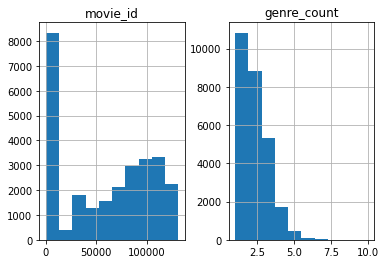

In [24]:
num_genres_per_movie_id.hist()
plt.show()

평균을 확인해봅시다.

In [25]:
num_genres_per_movie_id['genre_count'].mean()

1.9945010631277953

### (3) `ratings` 테이블 탐색하기

이번에는 `ratings` 데이터를 확인해봅시다.

In [26]:
pd.read_sql('DESC ratings', connect)

,Field,Type,Null,Key,Default,Extra
0,index,bigint(20),YES,MUL,None,
1,user_id,bigint(20),YES,,None,
2,movie_id,bigint(20),YES,,None,
3,rating,double,YES,,None,
4,rated_at,bigint(20),YES,,None,


`pd.DataFrame()`으로 데이터를 받아온 후 `rated_at`를 시간값으로 변환하기 위해서는 아래와 같이 작업하면 됩니다.

In [27]:
rating_df_10 = pd.read_sql(f'SELECT * from ratings limit 10', connect)

rating_df_10.rated_at = pd.to_datetime(rating_df_10.rated_at, unit='s')
rating_df_10.head()

,index,user_id,movie_id,rating,rated_at
0,0,1,2,3.5,2005-04-02 23:53:47
1,1,1,29,3.5,2005-04-02 23:31:16
2,2,1,32,3.5,2005-04-02 23:33:39
3,3,1,47,3.5,2005-04-02 23:32:07
4,4,1,50,3.5,2005-04-02 23:29:40


타임스탬프 값을 datetime으로 변경해주면 아래와 같이 시간 계산을 매우 편리하게 수행할 수 있습니다.<br>
혹은 sql 쿼리의 `from_unixtime`을 이용하여 바로 변환하여 볼 수도 있습니다.

In [28]:
pd.read_sql('''
SELECT *, 
FROM_UNIXTIME(rated_at) as rated_at_ymd 
FROM ratings limit 10''', connect)

,index,user_id,movie_id,rating,rated_at,rated_at_ymd
0,0,1,2,3.5,1112486027,2005-04-02 23:53:47
1,1,1,29,3.5,1112484676,2005-04-02 23:31:16
2,2,1,32,3.5,1112484819,2005-04-02 23:33:39
3,3,1,47,3.5,1112484727,2005-04-02 23:32:07
4,4,1,50,3.5,1112484580,2005-04-02 23:29:40
5,5,1,112,3.5,1094785740,2004-09-10 03:09:00
6,6,1,151,4.0,1094785734,2004-09-10 03:08:54
7,7,1,223,4.0,1112485573,2005-04-02 23:46:13
8,8,1,253,4.0,1112484940,2005-04-02 23:35:40
9,9,1,260,4.0,1112484826,2005-04-02 23:33:46


이번에는 연도별로 리뷰 수가 얼마나 되는지 알아봅시다.

In [29]:
yearly_rating_count = pd.read_sql('''
SELECT YEAR(FROM_UNIXTIME(rated_at)) AS rated_year,
COUNT(*) as count_ratings
FROM ratings
GROUP BY rated_year
ORDER BY rated_year''', connect)
yearly_rating_count.head()

,rated_year,count_ratings
0,1995,4
1,1996,1612609
2,1997,700982
3,1998,308070
4,1999,1198384


유저 별로 평균 선호도가 어떻게 되는지를 계산해 볼 수 있습니다.

In [30]:
user_rating_avg = pd.read_sql('''
SELECT user_id,  
AVG(rating) as mean_rating
FROM ratings
GROUP BY user_id''', connect)

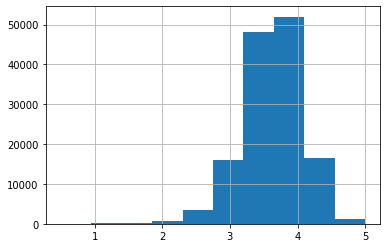

In [31]:
user_rating_avg['mean_rating'].hist()
plt.show()

유저들은 평균적으로 3~4점대의 평점을 많이 남기는 것을 알 수 있습니다. 

# \[ 비개인화 추천 : 아이템의 순위 매기기 \]
---

가장 간단한 형태의 추천은 **잘 나가는 제품 혹은 서비스**을 제시하는 것입니다. <br>
가장 평이 좋은 제품 혹은 가장 구매가 빈번한 제품, 최근에 나온 제품 등을 추천하는 것은 고객에 대한 정보가 전혀 없을 때 매우 유용합니다.<br>
그렇기 때문에 대부분의 커머스 사이트에서 랜딩 페이지에 인기 순위 혹은 신상을 소개하는 경우가 많습니다. <br>
판다스를  이용해 (1) 최신 아이템, (2) 최고 평점 아이템, (3) 최근 인기 아이템 리스트를 만들어보겠습니다.<br>

## 1. 최신(신규) 아이템 추천하기

> 최근에 나온 제품 있나요?

아이템의 출시일(발매일)을 기준으로 정렬을 하여, 가장 최근에 등장한 것들 위주로 가져올 수 있습니다. <br>
영화의 경우 출시시점에 따라 최신 순으로 나열할 수 있을 것입니다. `movies`데이터의 `release_year` 칼럼이 있으므로, 이를 기준으로 상위 10개 아이템을 뽑아보겠습니다. 

In [32]:
pd.read_sql("""
SELECT * 
FROM movies 
ORDER BY release_year DESC 
LIMIT 10""", connect)

,index,id,title,release_year
0,23865,113345,Jupiter Ascending,2015
1,24855,117466,In the Heart of the Sea,2015
2,25254,119145,Kingsman: The Secret Service,2015
3,25460,120466,Chappie,2015
4,25490,120635,Taken 3,2015
5,25491,120637,Blackhat,2015
6,25495,120757,Beck - Rum 302,2015
7,25527,120825,The Woman in Black 2: Angel of Death,2015
8,25786,122147,Beck - Familjen,2015
9,26049,124867,Justice League: Throne of Atlantis,2015


위와 같이 10개의 영화가 뽑혔습니다. 하지만 2015년에 출시된 영화는 이 외에도 많이 있죠. <br>
또한 연도만 있지 출시 월일이 없으므로 위의 아이템이 가장 최근에 출시된 영화라고 보기도 어렵습니다.<br>
<br>
이렇게 되면 최신 아이템 중에서 어떤 것은 노출되고 어떤 것은 노출되지 않는다는 단점이 있습니다. <br>
이런 경우, 간단히 아래와 같이 무작위로 최근에 등장한 아이템중에서 무작위로 선정하여 노출되는 아이템을 다양하게 해줍니다.<br>

In [33]:
pd.read_sql('''
SELECT * FROM movies
WHERE release_year = (
    SELECT MAX(release_year) 
    FROM movies
    )
ORDER BY RAND()
LIMIT 10
''', connect)

,index,id,title,release_year
0,26578,127323,Vice,2015
1,26530,127216,Unexpected,2015
2,26527,127210,Songs My Brothers Taught Me,2015
3,26928,129428,The Second Best Exotic Marigold Hotel,2015
4,26339,126548,The DUFF,2015
5,26598,127583,Chuck Norris vs Communism,2015
6,27116,130462,The Boy,2015
7,27095,130374,India's Daughter,2015
8,27117,130466,I Hate Christian Laettner,2015
9,26495,127138,Ten Thousand Saints,2015


## 2. 최고 평점 아이템 추천하기
> 평이 제일 좋은 물건은 무엇인가요?

평균 평점을 이용해 평이 제일 좋은 물건을 뽑아서 보여줄 수도 있을 것입니다.<br> 
다만, 평점이 높은 아이템을 뽑을 때는 한개, 두개의 평만 있는 것들은 제외시킬 필요가 있습니다.<br> 
충분히 많은 사람들로부터 검증받지 못한 것들은 그 평을 신뢰할 수 없기 때문입니다. <br>
보통 응답조사를 할 때 300명 이상을 유의미하다고 판단하기 때문에, 300명 이상 평가를 받은 영화들만 추려내도록 하겠습니다. <br>
<br>
먼저, 영화별 평균 평점과 리뷰의 수를 구하고, 300개 이상 평점을 받은 영화 중 Top 10을 선정하도록 하겠습니다.
<br>

In [34]:
# 300개 이상의 리뷰를 가진 영화 평점 가져오기
rating_movies_df_300 = pd.read_sql('''
SELECT movie_id, avg(rating), count(user_id)
FROM ratings
GROUP BY movie_id
HAVING count(user_id) >= 300
ORDER BY avg(rating) DESC
''', connect)
rating_movies_df_300

,movie_id,avg(rating),count(user_id)
0,318,4.446990,63366
1,858,4.364732,41355
2,50,4.334372,47006
3,527,4.310175,50054
4,1221,4.275641,27398
...,...,...,...
5721,6371,1.167692,325
5722,6587,1.164051,701
5723,1826,1.163484,419
5724,4775,1.124088,685


In [35]:
top10_rating_movies_df = rating_movies_df_300.sort_values("avg(rating)")[:10]
top10_rating_movies_df

,movie_id,avg(rating),count(user_id)
5725,6483,0.973005,426
5724,4775,1.124088,685
5723,1826,1.163484,419
5722,6587,1.164051,701
5721,6371,1.167692,325
5720,61348,1.251889,397
5719,31698,1.252677,467
5718,5672,1.316737,472
5717,6872,1.356823,447
5716,1495,1.390210,715


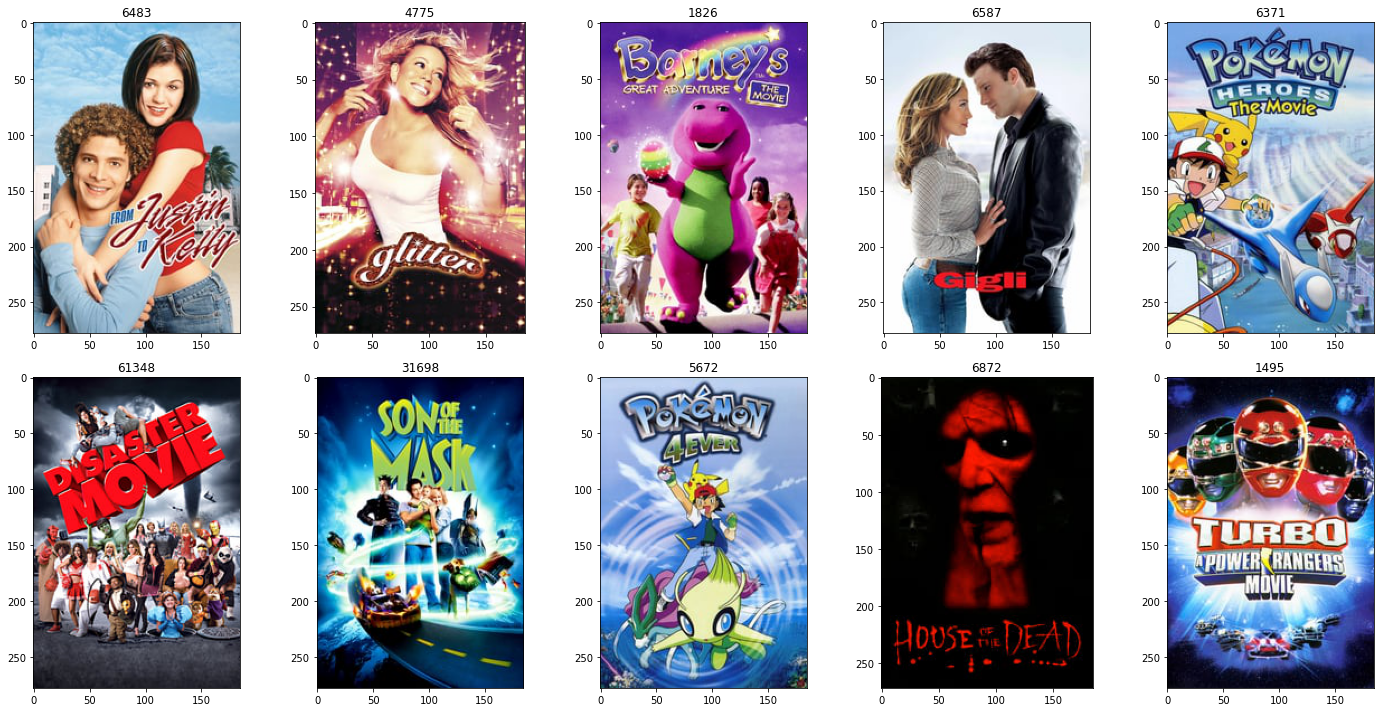

In [36]:
display_posters(top10_rating_movies_df['movie_id'].tolist())

결과를 보면, 다양한 분야의 영화가 인기 영화로 리스트업 된 것 같습니다. 다만 전체에서 평점이 높은 영화를 뽑다보니 다소 무거운 내용의 영화가 많이 뽑힌듯 합니다. <br>
장르 별로 최고 평점 영화들을 뽑아서 보여준다면, 특정 장르에 관심이 많은 유저에게 유용한 정보를 제공할 수 있을 것입니다. 이번에는 코미디 영화만 추려서 동일한 방법으로 최고 평점 영화를 뽑아봅시다. 


앞서 사용한 코드에서 `movie_id`의 장르가 코미디라는 조건을 추가해야 합니다. 

코미디 영화의 `movie_id`는 어떻게 알 수 있을까요? genre 테이블을 활용해야 합니다.

In [37]:
pd.read_sql("SELECT * FROM genres LIMIT 10", connect)

,index,movie_id,genre
0,0,1,Adventure
1,1,1,Animation
2,2,1,Children
3,3,1,Comedy
4,4,1,Fantasy
5,5,2,Adventure
6,6,2,Children
7,7,2,Fantasy
8,8,3,Comedy
9,9,3,Romance


In [38]:
comedy_movies = pd.read_sql("""
SELECT movie_id
FROM genres
WHERE genre = 'Comedy'
""", connect)

In [39]:
comedy_movies["movie_id"].values

array([     1,      3,      4, ..., 131252, 131254, 131256])

In [40]:
# 코미디 장르의 평점 데이터만을 가져오기
rating_comedy_df = rating_df[rating_df["movie_id"].isin(comedy_movies["movie_id"].tolist())]

In [41]:
rating_comedy_df

,index,user_id,movie_id,rating,rated_at
5,5,1,112,3.5,1094785740
7,7,1,223,4.0,1112485573
11,11,1,296,4.0,1112484767
14,14,1,367,3.5,1112485980
23,23,1,1079,4.0,1094785665
...,...,...,...,...,...
20000250,20000250,138493,59725,3.0,1255818078
20000251,20000251,138493,59784,5.0,1255816901
20000253,20000253,138493,60816,4.5,1259865163
20000256,20000256,138493,66762,4.5,1255805408


In [42]:
# 300개 이상의 리뷰를 가진 코미디 영화 평점 가져오기
comedy_movies_df_300 = rating_movies_df_300[rating_movies_df_300["movie_id"].isin(comedy_movies["movie_id"].tolist())]
comedy_movies_df_300

,movie_id,avg(rating),count(user_id)
11,750,4.247287,23220
29,4973,4.197072,24349
36,950,4.184187,3358
40,1148,4.181068,15022
43,1197,4.176732,32586
...,...,...,...
5713,4125,1.538462,455
5715,50798,1.488877,899
5719,31698,1.252677,467
5720,61348,1.251889,397


In [43]:
top10_rating_comedy_df = comedy_movies_df_300.head(10)

In [44]:
top10_rating_comedy_df

,movie_id,avg(rating),count(user_id)
11,750,4.247287,23220
29,4973,4.197072,24349
36,950,4.184187,3358
40,1148,4.181068,15022
43,1197,4.176732,32586
45,2324,4.175837,18156
46,296,4.174231,67310
47,1136,4.174146,33024
49,3307,4.174123,2593
51,1234,4.173556,14926


## 3. 최근 인기 아이템(HOT) 추천하기

> 요즘 사람들이 제일 많이 찾는 것이 무엇인가요?

영화의 평점이 높은 순으로 영화를 추천하게 되면 어떤 약점이 있을까요? 오래된 영화일수록 평가가 많이 쌓이게 되기 때문에, 과거 평가 기준으로 영화를 추천하게 됩니다. <br> 
최근에 개봉한 영화는 아직 평점이 많지 않아 추천되지 않을 수 있습니다. 최신 영화를 위주로 추천하고 싶다면, 아래와 같은 방식으로 최근 개봉영화만을 추려내어 
추천을 해야 합니다. <br>

가장 마지막 출시연도로부터 3년 이내의 영화를 뽑아봅시다.

In [45]:
recent_movies = pd.read_sql('''
SELECT *
FROM movies
WHERE release_year >= (
    SELECT max(release_year)-3 
    FROM movies
) 
''', connect)
recent_movies.sort_values('release_year').head(10)

,index,id,title,release_year
0,17874,89745,"Avengers, The",2012
922,21773,105275,I Will Follow You Into the Dark,2012
923,21776,105288,Ferocious,2012
924,21777,105290,Shanghai,2012
925,21781,105302,The Rise,2012
929,21797,105347,Quand je serai petit,2012
933,21802,105359,Future Weather,2012
934,21803,105364,Something in the Air (Apres Mai),2012
935,21805,105368,I Declare War,2012
937,21807,105377,"Puerta de Hierro, el exilio de Perón",2012


In [46]:
recent_movie_rating_df = rating_df[rating_df["movie_id"].isin(recent_movies["id"].tolist())]
recent_movie_rating_df

,index,user_id,movie_id,rating,rated_at
3767,3767,31,89745,5.0,1424733537
3768,3768,31,91500,4.5,1424733615
3769,3769,31,91529,5.0,1424734042
3770,3770,31,95167,3.0,1424735948
3771,3771,31,98809,4.5,1424733634
...,...,...,...,...,...
19997256,19997256,138471,91529,2.5,1355631584
19997259,19997259,138471,94780,4.0,1355633223
19997260,19997260,138471,95167,4.0,1355633017
19997261,19997261,138471,97913,3.5,1355632405


In [47]:
top10_recent_movies = (
    recent_movie_rating_df
    .filter(["movie_id", "rating"])
    .groupby("movie_id")
    .mean()
    .sort_values("rating")
    .head(10)
)
top10_recent_movies

,rating
movie_id,
120580,0.5
130392,0.5
130682,0.5
110800,0.5
110802,0.5
128175,0.5
120222,0.5
110984,0.5
111046,0.5


`top10_recent_movies`영화를 기준으로 앞서 인기 영화를 뽑은 기준을 그대로 적영하여 최근 인기 아이템을 뽑아보겠습니다. <br>
결과를 확인해보면, 앞서 전체 데이터에서 인기 영화를 뽑았을 때에는 보이지 않았던 최신 영화가 리스트됨을 알 수 있습니다. 

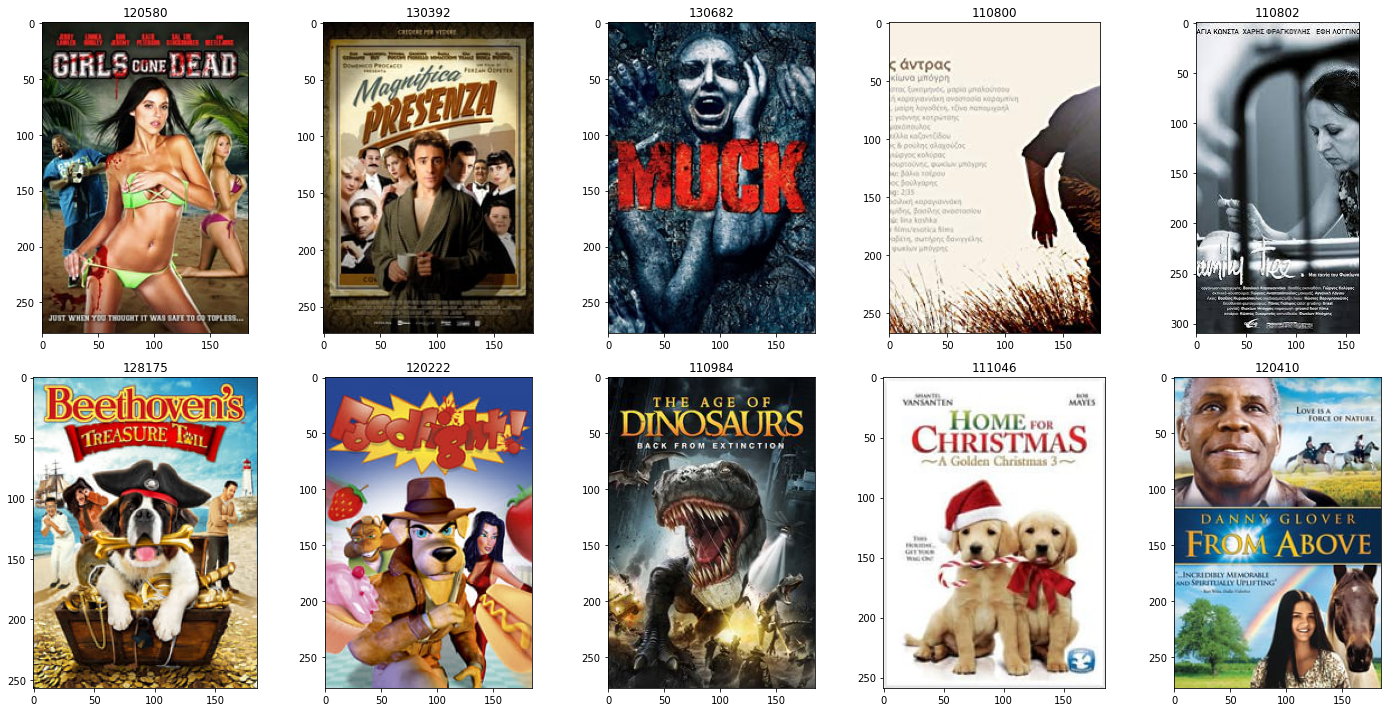

In [48]:
display_posters(top10_recent_movies.index.tolist())

#  

---

    Copyright(c) 2020 by Public AI. All rights reserved.
    Writen by PAI, SeonYoul Choi ( best10@publicai.co.kr )  last updated on 2020/05/30


---